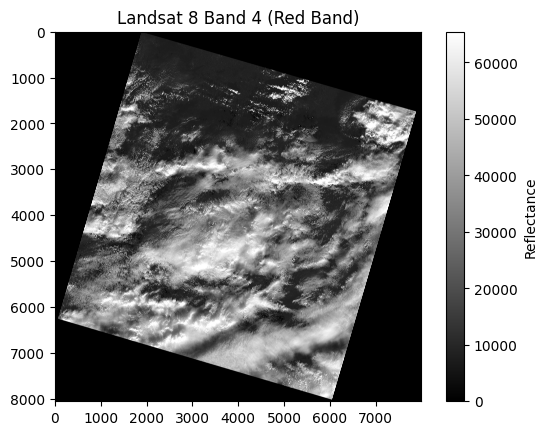

In [22]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the Landsat 8 Band 4 image
image_path = "data/LC08_L2SP_196024_20241117_20241126_02_T2_SR_B4.TIF"
with rasterio.open(image_path) as src:
    image = src.read(1)  # Read the first band (Red Band)
    metadata = src.meta  # Metadata (e.g., CRS, transform)

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title("Landsat 8 Band 4 (Red Band)")
plt.colorbar(label="Reflectance")
plt.show()

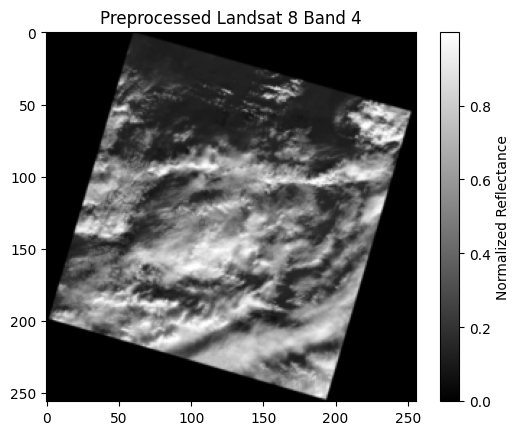

In [23]:
from skimage.transform import resize

# Normalize the image to [0, 1]
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))

# Resize the image (optional)
image_resized = resize(image_normalized, (256, 256), anti_aliasing=True)

# Visualize the preprocessed image
plt.imshow(image_resized, cmap='gray')
plt.title("Preprocessed Landsat 8 Band 4")
plt.colorbar(label="Normalized Reflectance")
plt.show()

In [24]:
import torch
import torch.nn as nn

class UNetISP(nn.Module):
    def __init__(self):
        super(UNetISP, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the U-Net model
isp_model = UNetISP()
print(isp_model)

UNetISP(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


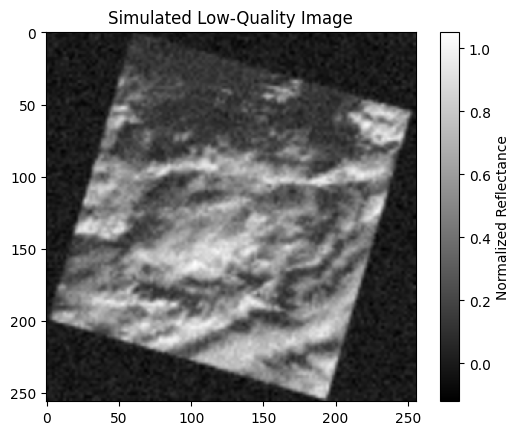

In [26]:
# Convert the image to a PyTorch tensor
image_tensor = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]

# Simulate a low-quality version (e.g., add noise and downsample)
import torch.nn.functional as F

# Add Gaussian noise
noise = torch.randn_like(image_tensor) * 0.1
low_quality_image = image_tensor + noise

# Downsample the image
low_quality_image = F.interpolate(low_quality_image, scale_factor=0.5, mode='bilinear', align_corners=False)
low_quality_image = F.interpolate(low_quality_image, scale_factor=2.0, mode='bilinear', align_corners=False)  # Upsample back to original size

# Visualize the low-quality image
plt.imshow(low_quality_image.squeeze().numpy(), cmap='gray')
plt.title("Simulated Low-Quality Image")
plt.colorbar(label="Normalized Reflectance")
plt.show()

In [31]:
from torchmetrics import StructuralSimilarityIndexMeasure

# Initialize SSIM loss
ssim_loss = StructuralSimilarityIndexMeasure(data_range=1.0)

# Define optimizer
optimizer = torch.optim.Adam(isp_model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):  # Train for 100 epochs
    optimizer.zero_grad()
    output = isp_model(low_quality_image)
    loss = 1 - ssim_loss(output, image_tensor)  # Maximize SSIM (minimize 1 - SSIM)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1, Loss: 0.9073814749717712
Epoch 2, Loss: 0.8197266459465027
Epoch 3, Loss: 0.6965778470039368
Epoch 4, Loss: 0.5809577107429504
Epoch 5, Loss: 0.38172268867492676
Epoch 6, Loss: 0.5366634130477905
Epoch 7, Loss: 0.5160799026489258
Epoch 8, Loss: 0.5378333330154419
Epoch 9, Loss: 0.5289703011512756
Epoch 10, Loss: 0.490786612033844
Epoch 11, Loss: 0.35571372509002686
Epoch 12, Loss: 0.5280225276947021
Epoch 13, Loss: 0.5521910190582275
Epoch 14, Loss: 0.5553873181343079
Epoch 15, Loss: 0.5519541501998901
Epoch 16, Loss: 0.5512237548828125
Epoch 17, Loss: 0.553573489189148
Epoch 18, Loss: 0.5541338920593262
Epoch 19, Loss: 0.5453412532806396
Epoch 20, Loss: 0.5276923179626465
Epoch 21, Loss: 0.5120492577552795
Epoch 22, Loss: 0.5013161301612854
Epoch 23, Loss: 0.4915488362312317
Epoch 24, Loss: 0.4780832529067993
Epoch 25, Loss: 0.46253663301467896
Epoch 26, Loss: 0.4547683596611023
Epoch 27, Loss: 0.45467787981033325
Epoch 28, Loss: 0.44032377004623413
Epoch 29, Loss: 0.35128235

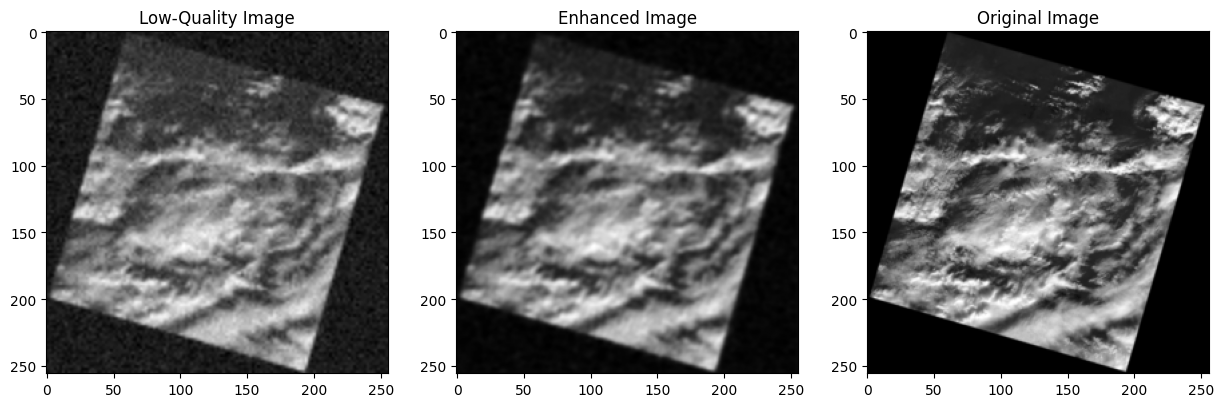

In [32]:
# Enhance the low-quality image
enhanced_image = isp_model(low_quality_image)

# Visualize the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(low_quality_image.squeeze().numpy(), cmap='gray')
plt.title("Low-Quality Image")
plt.subplot(1, 3, 2)
plt.imshow(enhanced_image.squeeze().detach().numpy(), cmap='gray')  # Squeeze to remove the batch dimension
plt.title("Enhanced Image")
plt.subplot(1, 3, 3)
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.title("Original Image")
plt.show()

In [33]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Convert images to NumPy arrays
original_image_np = image_tensor.squeeze().numpy()
enhanced_image_np = enhanced_image.squeeze().detach().numpy()
low_quality_image_np = low_quality_image.squeeze().numpy()

# Calculate PSNR
psnr_original_vs_enhanced = psnr(original_image_np, enhanced_image_np, data_range=1.0)
psnr_original_vs_low_quality = psnr(original_image_np, low_quality_image_np, data_range=1.0)

# Calculate SSIM
ssim_original_vs_enhanced = ssim(original_image_np, enhanced_image_np, data_range=1.0)
ssim_original_vs_low_quality = ssim(original_image_np, low_quality_image_np, data_range=1.0)

# Calculate MSE
mse_original_vs_enhanced = np.mean((original_image_np - enhanced_image_np) ** 2)
mse_original_vs_low_quality = np.mean((original_image_np - low_quality_image_np) ** 2)

# Print the results
print("PSNR (Original vs Enhanced):", psnr_original_vs_enhanced)
print("PSNR (Original vs Low-Quality):", psnr_original_vs_low_quality)
print("SSIM (Original vs Enhanced):", ssim_original_vs_enhanced)
print("SSIM (Original vs Low-Quality):", ssim_original_vs_low_quality)
print("MSE (Original vs Enhanced):", mse_original_vs_enhanced)
print("MSE (Original vs Low-Quality):", mse_original_vs_low_quality)

PSNR (Original vs Enhanced): 12.496869937356214
PSNR (Original vs Low-Quality): 26.808922735966586
SSIM (Original vs Enhanced): 0.6697721869384945
SSIM (Original vs Low-Quality): 0.6827320670648217
MSE (Original vs Enhanced): 0.05627468
MSE (Original vs Low-Quality): 0.002085008


In [34]:
class UNetISP(nn.Module):
    def __init__(self):
        super(UNetISP, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the deeper U-Net model
isp_model = UNetISP()
print(isp_model)

UNetISP(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [1]:
from torchvision.models import vgg16
from torchvision.models.feature_extraction import create_feature_extractor

# Load a pre-trained VGG16 model for perceptual loss
vgg_model = vgg16(pretrained=True).features[:16]  # Use the first 16 layers
vgg_model = vgg_model.eval()  # Set to evaluation mode

# Define perceptual loss
def perceptual_loss(output, target):
    # Extract features from VGG16
    output_features = vgg_model(output)
    target_features = vgg_model(target)
    # Compute MSE between features
    return F.mse_loss(output_features, target_features)

# Combine SSIM loss and perceptual loss
def combined_loss(output, target):
    ssim = ssim_loss(output, target)
    perceptual = perceptual_loss(output, target)
    return (1 - ssim) + perceptual  # Minimize both losses

ModuleNotFoundError: No module named 'torchvision'

In [20]:
print("Original image shape:", original_image_np.shape)
print("Low-quality image shape:", low_quality_image_np.shape)
print("Enhanced image shape:", enhanced_image_np.shape)

Original image shape: (256, 256)
Low-quality image shape: (256, 256)
Enhanced image shape: (256, 256)


In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Calculate PSNR
psnr_original_vs_enhanced = psnr(original_image_np, enhanced_image_np, data_range=1.0)
psnr_original_vs_low_quality = psnr(original_image_np, low_quality_image_np, data_range=1.0)

# Calculate SSIM
ssim_original_vs_enhanced = ssim(original_image_np, enhanced_image_np, data_range=1.0)
ssim_original_vs_low_quality = ssim(original_image_np, low_quality_image_np, data_range=1.0)

# Calculate MSE
mse_original_vs_enhanced = np.mean((original_image_np - enhanced_image_np) ** 2)
mse_original_vs_low_quality = np.mean((original_image_np - low_quality_image_np) ** 2)

# Print the results
print("PSNR (Original vs Enhanced):", psnr_original_vs_enhanced)
print("PSNR (Original vs Low-Quality):", psnr_original_vs_low_quality)
print("SSIM (Original vs Enhanced):", ssim_original_vs_enhanced)
print("SSIM (Original vs Low-Quality):", ssim_original_vs_low_quality)
print("MSE (Original vs Enhanced):", mse_original_vs_enhanced)
print("MSE (Original vs Low-Quality):", mse_original_vs_low_quality)

PSNR (Original vs Enhanced): 22.9923664005257
PSNR (Original vs Low-Quality): 26.733128496219315
SSIM (Original vs Enhanced): 0.6143059922006189
SSIM (Original vs Low-Quality): 0.6766215318185687
MSE (Original vs Enhanced): 0.0050206897
MSE (Original vs Low-Quality): 0.0021217153
